# Read tiles to input format VAE network

### Imports
Install tensorflow:
``%pip install tensorflow``

In [1]:
#%pip install tensorflow

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### Create sampling layer

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


### Build encoder


In [4]:
latent_dim = 2
encoder_inputs = keras.Input(shape=(20, 20,3)) # enter cut-out shape (20,20,3)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x) # to vector
x = layers.Dense(16, activation="relu")(x) # linked layer
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 20, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 10, 10, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 5, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1600)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

### Build decoder

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(5 * 5 * 64, activation="relu")(latent_inputs) # -- shape corresponding to encoder
x = layers.Reshape((5, 5, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x) # (1,3) or (3,3)


decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1600)              4800      
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 20, 20, 3)         867       
Total params: 61,059
Trainable params: 61,059
Non-trainable params: 0
_______________________________________________________

## Define VAE as model
With custom train_step

In [6]:

# class VAE(keras.Model):
#     def __init__(self, encoder, decoder, **kwargs):
#         super(VAE, self).__init__(**kwargs)
#         self.encoder = encoder
#         self.decoder = decoder
#         self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
#         self.reconstruction_loss_tracker = keras.metrics.Mean(
#             name="reconstruction_loss"
#         )
#         self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

#     @property
#     def metrics(self):
#         return [
#             self.total_loss_tracker,
#             self.reconstruction_loss_tracker,
#             self.kl_loss_tracker,
#         ]

#     def train_step(self, data):
#         with tf.GradientTape() as tape:
#             z_mean, z_log_var, z = self.encoder(data)
#             reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
#             kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
#             total_loss = reconstruction_loss + kl_loss
#         grads = tape.gradient(total_loss, self.trainable_weights)
#         self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
#         self.total_loss_tracker.update_state(total_loss)
#         self.reconstruction_loss_tracker.update_state(reconstruction_loss)
#         self.kl_loss_tracker.update_state(kl_loss)
#         return {
#             "loss": self.total_loss_tracker.result(),
#             "reconstruction_loss": self.reconstruction_loss_tracker.result(),
#             "kl_loss": self.kl_loss_tracker.result(),
#         }

Update: instead of defining VAE as class, use function-wise definition

In [7]:
# Define VAE model.###################################### the whole cell has changed
outputs = decoder(z)
vae = tf.keras.Model(inputs=encoder_inputs, outputs=outputs, name="vae")

# Add KL divergence regularization loss.
reconstruction = decoder(z)
reconstruction_loss = tf.reduce_mean(
    tf.reduce_sum(
        keras.losses.binary_crossentropy(encoder_inputs, reconstruction), axis=(1, 2)
                )
            )
kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

alpha = 1.0 

# Play witht different alpha: -2, 0 , 1 ,2 ; 0.2 ; -0.5 ; 50
alpha = 10.; 
total_loss = reconstruction_loss +  alpha * kl_loss # alpha is custom
vae.add_loss(total_loss)

## Load Data

### mnist dataset

In [8]:
# (x_train, _), (x_test, _) = keras.datasets.mnist.load_data() # reads data as numpy.ndarray

# mnist_digits = np.concatenate([x_train, x_test], axis=0) # [70000,28,28]
# print(type(mnist_digits), np.shape(mnist_digits))

# mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255  # adds 4th dimension (bands) [70000,28,28,1]
# print(type(mnist_digits),np.shape(mnist_digits))



# Load labelled tile

In [9]:
import rioxarray
import xarray as xr
import numpy as np

In [10]:

dataPath = '/Users/maaikeizeboud/Documents/Data/test/'
imName = 'test_labelled_tile.tif'

In [11]:
tile = rioxarray.open_rasterio(dataPath + imName)
tile.isnull().any()

<xarray.DataArray ()>
array(False)
Coordinates:
    spatial_ref  int64 0

In [12]:
# tile

In [13]:
tile.attrs

{'scale_factor': 1.0, 'add_offset': 0.0, 'grid_mapping': 'spatial_ref'}

### Make cut-out with xarray rolling window

In [14]:
# initialise rolling object
rolling = tile.rolling(
    x=20,
    y=20,
)
rolling

DataArrayRolling [x->20,y->20]

In [15]:

cutouts = rolling.construct(
    {'x':'x_win', 'y': 'y_win'}, 
    stride={'x': 15, 'y': 15}, # windwo_listing uses 'overlap' of 5, which is a stride of 15 for a window of 20pixels
)

In [16]:
cutouts.shape

(4, 667, 667, 20, 20)

In [17]:
# cutouts.isnull().any()

#### Reshape cut-outs 

from dataArray <xarray.DataArray (band: 4, y: 667, x: 667, x_win: 20, y_win: 20)>

to (n: 667*667 , x_win: 20, y_win: 20, bands: 4)

In [18]:
windowlist = cutouts.stack(sample=("y","x"))
windows = windowlist.transpose("sample","x_win","y_win","band")


In [19]:
windows.shape

(444889, 20, 20, 4)

#### issue: cutouts along the edge of the original raster are filled with NaN's - remove

In [20]:
windows.attrs["long_name"] = "bands"
# windows.isel(band=0, sample=0).plot.imshow()

In [21]:
# drop all NaN-containing cutouts - also useful if array has been masked with coastline shape
windows = windows.dropna(dim="sample", how="any")
windows.shape

(442225, 20, 20, 4)

In [22]:
# windows.isel(band=0, sample=0).plot.imshow()

In [23]:
windows.isnull().any()

<xarray.DataArray ()>
array(False)
Coordinates:
    spatial_ref  int64 0

### Make x_train and y_train
Test with fewer samples than in full dataset

In [24]:
x_train = windows[:,:,:,0:3]
y_train = windows[:,:,:,-1]
print(x_train.shape,y_train.shape)

(442225, 20, 20, 3) (442225, 20, 20)


#### Convert xarray.DataArray to numpy ndarray

In [25]:
x_train = x_train.values
y_train = y_train.values

### Normalise data

In [26]:
# print(x_train.max(),x_train.min())
print(np.min(x_train),np.max(x_train))

1.0 17264.0


In [27]:
imax = np.max(x_train) # 15.000-ish
x_train_norm = (x_train+0.1)/ (imax+1) 


In [28]:
print('0-values in data: ',np.any(x_train_norm == 0))
print('1-values in data: ',np.any(x_train_norm == 1))


0-values in data:  False
1-values in data:  False


Normalise to INCLUDE 0 and 1 (just as mnist dataset)

In [29]:
# x_train_norm = (x_train)/ (imax) 
# print(x_train_norm.min(), x_train_norm.max())

### Process labels
Each window has a mask on pixel-basis. Convert this to label-per-window
- Sum all pixels in the window
- normalise the values to be 0-1: now we do not have binary label but range label, depending on fracture of window that is classified as crack.

In [30]:
y_train.shape

(442225, 20, 20)

In [31]:
y_label = np.sum(y_train,axis=2)
y_label = np.sum(y_label,axis=1)
y_label.shape

(442225,)

In [32]:
len(y_label[np.where( y_label > 0 )]) # number of windows with label > 0
print(len(y_label[np.where( y_label > 0 )])/len(y_label))

0.00684040929391147


In [33]:
print(np.min(y_label),np.max(y_label))
y_label_norm = (y_label)/ np.max(y_label) # normalise including 0,1 boundaries

print(np.min(y_label_norm),np.max(y_label_norm))


0.0 400.0
0.0 1.0


# Train model

Make test-selection of data

In [34]:
# sort data in descending label value:
y_sort = y_label_norm[np.argsort(-y_label_norm)]
x_sort = x_train_norm[np.argsort(-y_label_norm),:,:,:]


In [35]:
# find number of label>1:
# keep 20% of pixels with label>0 for testing 
idx_train = int(0.8*np.argmax(y_sort == 0))
idx_train

2420

In [36]:
# # select subset:
# N = 12000;
N = idx_train*2;

# select half of samples with label=1, half with label=0
x_select = np.concatenate((x_sort[:int(N/2),:,:,:] , x_sort[-int(N/2):,:,:,:] ))
y_select = np.concatenate((y_sort[:int(N/2) ] , y_sort[-int(N/2):] ))
print(x_select.shape, y_select.min(),y_select.max())

(4840, 20, 20, 3) 0.0 1.0


In [37]:
Ns = int(N/2)
Ne = int(N/2)+int(N/2)
x_test = np.concatenate(( x_sort[Ns:Ne,:,:,:] , x_sort[-Ne:-Ns,:,:,:] ))
y_test = np.concatenate(( y_sort[Ns:Ne ] , y_sort[-Ne:-Ns] ))
x_test.shape
print(x_test.shape,y_test.min(),y_test.max())

(4840, 20, 20, 3) 0.0 1.0


Make test-selection of data: simpel selecion

In [38]:
# x_train_norm.shape

In [39]:
# N = 30000

In [40]:
# x_select = x_train_norm[:N,:,:,:]
# y_select = y_label_norm[:N]
# x_select.shape

Perform training

In [46]:
# select data: 

# data = x_train_norm
data = x_select;

# train with class-defined VAE:

# vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam())
# vae.fit(data, epochs=10, batch_size=128)

# train including validation loss:
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(data, epochs=20, batch_size=128, validation_split=0.3)######################### this line has changed

# batch size variation: 16 - 32 - 64 - 128 etc

Epoch 1/20
27/27 [==============================] - 3s 68ms/step - loss: 276.5861 - val_loss: 276.3924
Epoch 2/20
27/27 [==============================] - 1s 53ms/step - loss: 276.5977 - val_loss: 276.3661
Epoch 3/20
27/27 [==============================] - 1s 52ms/step - loss: 276.5943 - val_loss: 276.3916
Epoch 4/20
27/27 [==============================] - 1s 52ms/step - loss: 276.6031 - val_loss: 276.4044
Epoch 5/20
27/27 [==============================] - 1s 53ms/step - loss: 276.5903 - val_loss: 276.3891
Epoch 6/20
27/27 [==============================] - 2s 57ms/step - loss: 276.5855 - val_loss: 276.4375
Epoch 7/20
27/27 [==============================] - 1s 52ms/step - loss: 276.5737 - val_loss: 276.4566
Epoch 8/20
27/27 [==============================] - 1s 54ms/step - loss: 276.6033 - val_loss: 276.3771
Epoch 9/20
27/27 [==============================] - 1s 52ms/step - loss: 276.5960 - val_loss: 276.3857
Epoch 10/20
27/27 [==============================] - 1s 53ms/step - loss:

## Display grid of sampled images
For the current training-test, the sampled images are very uniform grey data - which makes sense as the network does not distinguish any features yet with this little of training.

In [ ]:
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

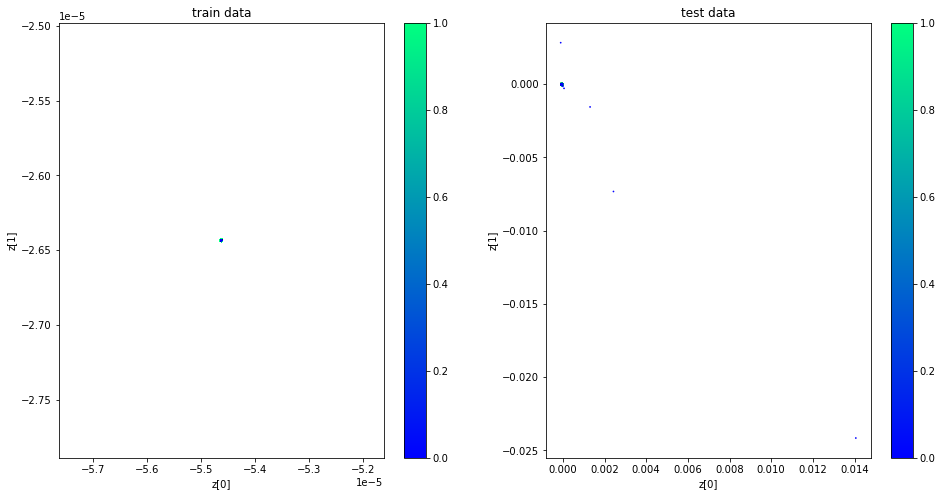

In [44]:

def plot_label_clusters2(vae, data,labels):
    
    # display a 2D plot of the digit classes in the latent space
    
    z_mean, _, _ = encoder.predict(data) ###################################### this line has changed
    z_mean = z_mean[z_mean[:,0].argsort()] # sort for 1 column 
    # I didnt sort the labels...
    labels = labels[z_mean[:,0].argsort()]
#     z_mean = np.sort(z_mean, axis=0)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels,s=(labels+0.1)*5) # also add size for scatter point
#     plt.scatter(z_mean[:,0],z_mean[:,1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

def plot_label_clusters3(vae, x_train,y_train,x_test,y_test):    
    # -- SUBPLOT WITH TRAIN & TEST clusters
    
    z_mean_train, _, _ = encoder.predict(x_train) 
    z_mean_test, _, _  = encoder.predict(x_test)
#     z_mean = z_mean[z_mean[:,0].argsort()] # sort for 1 column
#     y_train = y_train[z_mean[:,0].argsort()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,8))
    
    s1 = ax1.scatter(z_mean_train[:, 0], z_mean_train[:, 1], c=y_train,s=(y_train+0.1)*5,cmap='winter') # also add size for scatter point
    ax1.set_title('train data'); 
    ax1.set_xlabel("z[0]"); 
    ax1.set_ylabel("z[1]")
    fig.colorbar(s1,ax=ax1); #ax2.colorbar()
    
    s2 = ax2.scatter(z_mean_test[:, 0], z_mean_test[:, 1], c=y_test,s=(y_test+0.1)*5,cmap='winter') # also add size for scatter point
    ax2.set_title('test data'); 
    ax2.set_xlabel("z[0]"); 
    ax2.set_ylabel("z[1]")
    fig.colorbar(s2,ax=ax2); #ax2.colorbar()

# (x_train, y_train), _ = keras.datasets.mnist.load_data()
# x_train = np.expand_dims(x_train, -1).astype("float32") / 255


# plot_label_clusters2(vae, x_test, y_test)
# plot_label_clusters2(vae, x_select, y_select)
plot_label_clusters3(vae, x_select, y_select,x_test,y_test)




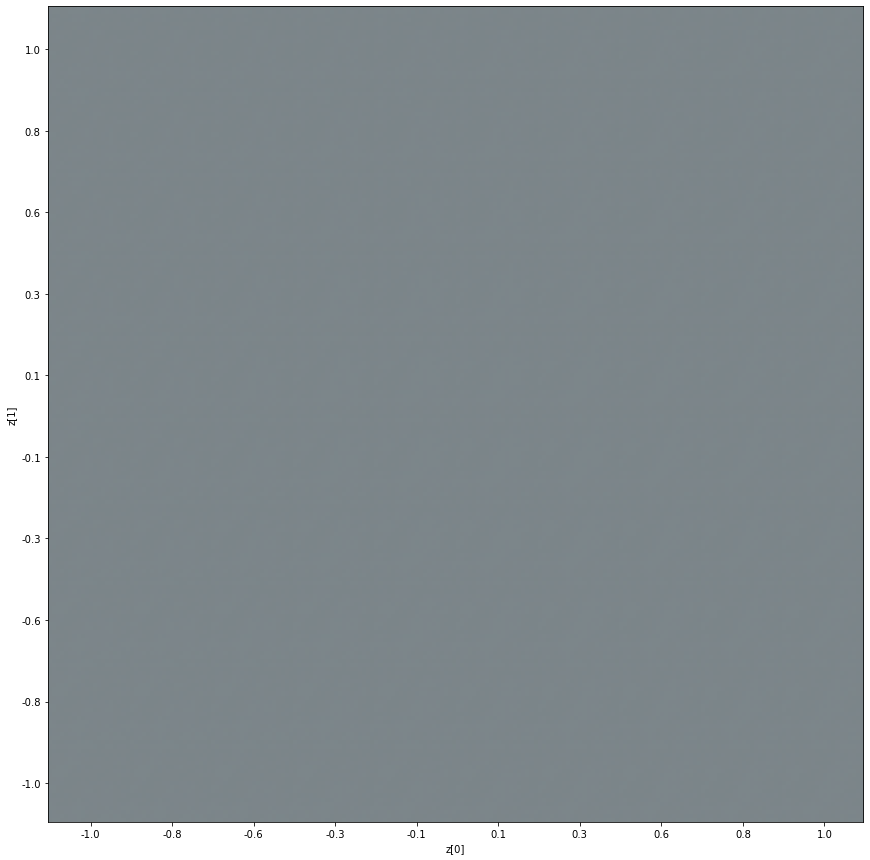

In [42]:


def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 20
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n,3)) #add 3rd dim
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
#             x_decoded = vae.decoder.predict(z_sample)
            x_decoded = decoder.predict(z_sample) ######################## this line has changed
#             print(x_decoded[0].shape) #[20,20,3]
            digit = x_decoded[0]#.reshape(digit_size, digit_size) # do not reshape: keep all 3 bands
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
                : # add all 3 bands
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='viridis')#"Greys_r")
    plt.show()


# plot_latent_space(vae)

## Display latent space clustering

In [43]:

# def plot_label_clusters(vae, data,labels):
#     # display a 2D plot of the digit classes in the latent space
# #     z_mean, _, _ = vae.encoder.predict(data)
#     z_mean, _, _ = encoder.predict(data) ###################################### this line has changed
#     plt.figure(figsize=(12, 10))
#     plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
# #     plt.scatter(z_mean[:,0],z_mean[:,1])
#     plt.colorbar()
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
#     plt.show()


# # (x_train, y_train), _ = keras.datasets.mnist.load_data()
# # x_train = np.expand_dims(x_train, -1).astype("float32") / 255

# plot_label_clusters(vae, x_train_norm, y_label_norm)

TMP: try to find fault in sorted plotting 
- it turned out to be the sorting of the labels

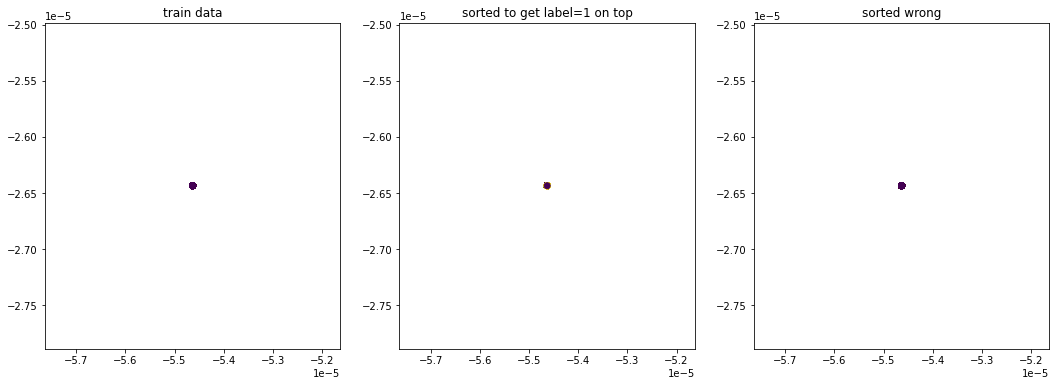

In [45]:
# z_mean, _, _ = encoder.predict(x_select)
# z_sort = np.sort(z_mean, axis=0)
# z_sort2 = z_mean[z_mean[:,0].argsort()]
# y_sort2 = y_select[z_mean[:,0].argsort()]

# fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
# ax1.scatter(z_mean[:,0],z_mean[:,1],c=y_select)
# ax1.set_title('train data')
# ax2.scatter(z_sort2[:,0],z_sort2[:,1],c=y_sort2)
# ax2.set_title('sorted to get label=1 on top')
# ax3.scatter(z_sort2[:,0],z_sort2[:,1],c=y_select)
# ax3.set_title('sorted wrong');
